# 17. 다음에 볼 영화 예측하기  

## 17-1. 들어가며  
### 1. Session-Based Recommendation  
전자상거래 플랫폼에서 사용하는 Session-Based Recommendation에 대해 알아보자.  

고객과 유사한 다른 고객의 좋아하는 상품을 추천해주는 전략은 맹점이 있다.  
고객의 선호가 바뀌기에 전자상거래 플랫폼에서는 지금 시점에 좋아할만한 제품을 추천하고 싶습니다.

Session-Based Recommendation은 말그대로 세션 데이터 기반으로 유저가 다음에 클릭하거나 구매할 상품을 예측하는 추천.  
여기서 Session은 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터로 서버에 저장된다.  
유저행동데이터는 유저의 브라우저를 통해 쿠키형태로 저장되고, 쿠키는 세션과 상호작용하며 정보를 주고 받는다.  
이번 노드에서는 세션을 브라우저종료전까지 유저행동이 담긴 시퀀스데이터로 생각한다.  
  
쿠키는 사이트를 방문하고 이용할 때 브라우저에 저장되는 내용 브라우저가 내 컴퓨터에 있기에 내가 갖고 있다.
쿠키는 쉽게 수정되고 탈취될 수 있어 중요한 정보는 저장하지 않는다.
세션을 사용하는 사이트에 접속시 서버에서 사용자 구분을 위한 기한 짧은 임시 키 하나를 브라우저에 보내 쿠키로 저장  
사용자의 중요한 정보는 서버의 메모리나 데이터베이스에 저장
사이트에 접속때마다 브라우저가 키를 서버에 보내면 서버는 사용자의 정보를 가공해서 응답  
노출되서는 안되는 정보들은 서비스 제공자가 세션으로 서버 안에서 다뤄진다.
웹사이트 개발시에 쿠키로 저장할지, 세션으로 정할지 잘 정해야 한다.  
캐시는 가져오는데 비용이 든 데이터를 한번 가져온 뒤에 임시로 저장
사용자가 자주 올 사이트의 이미지등을 사용자의 컴퓨터나 중간 서버에 저장  
  
  
오늘은 YOOCHOOSE라는 추천엔진솔류션회사에서 E-Comemerce데이터를 공개했는데 이 데이터를 활용할 것입니다.  

```
$ mkdir -p ~/aiffel/yoochoose-data
$ cd ~/aiffel
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/yoochoose-data.7z
$ sudo apt install p7zip-full
$ 7z x yoochoose-data.7z -oyoochoose-data
```


In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose-data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

설명을 보면 주목할 만한 몇가지 특징이 있습니다.  
  1. 유저의 정보를 알 수 없다.(성별, 주소, 이름...)
  2. 아이템의 정보도 알 수 없다.(어떤 물건인지, 가격)
  
유저에 대한 정보를 알 수 있는 경우는 Sequential Recommendation이라고 한다.  
Sequential Recommendation은 Context-Aware분야에서 사용.  

E-Commerce 데이터 특징.  
  1. 비로그인 상태에서 탐색하는 유저가 많다.  
  2. 로그인 상태여도 접속할 때마다 탐색하는 의도가 다르다.
  

## 17-2. Data Preprocess  
### 2.1 Data Load  
  * 데이터를 불러와 살펴보고 주요 통계치 확인
  * 이번 자료에서 Click 데이터의 Session Id, TimeStamp, ItemId 칼럼만 사용.
  
pathlib이 설치되어있는지 확인
```
$ pip list | grep pathlib
$ pip install pathlib
```

In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/home/ssac19/aiffel/yoochoose-data/yoochoose-clicks.dat')

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [5]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


추천시스템 구축시 먼저 확인할 것은 유저수(세션), 아이템수

In [6]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

### 2.2 Session Length
각 세션이 몇개의 클릭데이터가 있는지 확인

In [7]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

session_length란 같은 SessionId를 공유하는 데이터 row의 개수  
SessionId란 브라우저에서 웹서버 접속시 항상 포함되는 유저구분자  
로그인을 하지않아도 SessionId로 구분가능  
session_length는 해당 세션 사용자가 그 세션동안 몇번 액션했는지를 의미

In [8]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [9]:
session_length.min(), session_length.max()

(1, 200)

In [10]:
session_length.quantile(0.999)

41.0

세션 길이 평균이 2~3이고 99.9%가 41이하인데, 200이 최고라고 뜨니 이상하다.  

In [11]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


매우 짧은 간격으로 지속적으로 클릭을 1시반동안 지속.  
사용자의 이용형태는 다 다르기에 전처리를 어떻게 해야할지 고민해야 한다.  
음악을 하루종일 랜덤재생하는 사람의 데이터를 어떻게 해야할까?
어떤 상품의 평점이 1분만에 20명이 만점을 줬는데, 자기 제품을 팔기위해서 억지로 평점을 올린게 아닐까?  
세션길이를 시각화해보자  
아래는 세션길이의 누적합

In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.136189
2     0.520858
3     0.695280
4     0.796461
5     0.855125
6     0.894389
7     0.920036
8     0.938321
9     0.951293
10    0.961084
11    0.968267
12    0.973959
13    0.978320
14    0.981815
15    0.984587
16    0.986837
17    0.988673
18    0.990201
19    0.991460
20    0.992520
21    0.993436
22    0.994207
23    0.994871
24    0.995444
25    0.995920
26    0.996342
27    0.996714
28    0.997042
29    0.997330
30    0.997577
31    0.997796
32    0.998001
33    0.998177
34    0.998327
35    0.998461
36    0.998590
37    0.998706
38    0.998805
39    0.998896
40    0.998981
dtype: float64

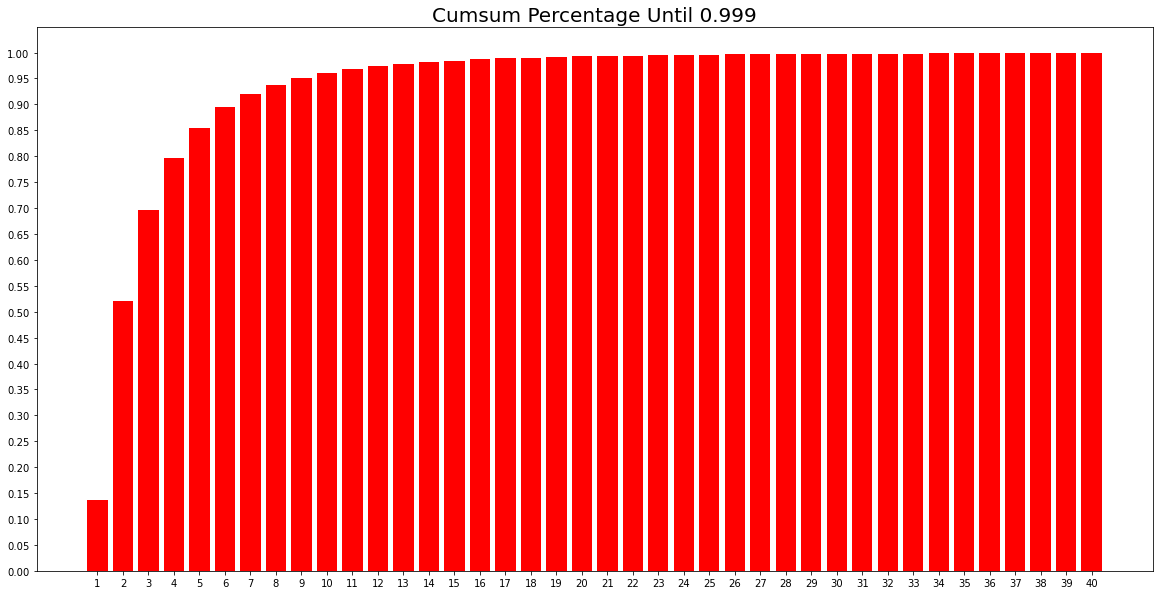

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

Q1. 추천시스템은 유저-상품 관계 매트릭스를 유저 행렬과 상품 행렬의 곱으로 표현하는 Matrix Factorization 모델을 널리 사용합니다. 
그렇다면 이 데이터도 유저와 클릭한 상품정보 관계에 대해 Matrix Factorization을 사용하면 어떨까요?  
Answer: User * Item Matrix의 빈칸이 너무 많아서(data sparsity) 모델이 제대로 학습되지 않을 가능성이 있다. 이 세션정보는 유저를 ID 기반으로 정리할 수 없기 때문에 세션 하나를 유저 하나로 본다면 기존의 유저-상품정보 Matrix보다 훨씬 sparse한 형태가 된다.  
  
### 2.3 Session Time  
Q2. 추천 시스템에서 다루는 시간 관련 데이터는 다양한 측면이 있습니다. 데이터 생성 날짜 말고 또 어떤 요소가 있을까요?  
Answer: 접속하는 시간대(오전, 오후, 새벽), 접속해 있는 시간, 접속하는 요일, 계절, 마지막 접속 시간, 장바구니에 넣고 지난 시간 등등

In [14]:
# 우리가 다루는 데이터의 시간정보
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


6개월치 데이터이나 1달만 사용할 것이다. 6개월 데이터를 사용하면 성능이 더 좋아질까?

In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이므로 int 객체와 사칙연산 지원X
날짜끼리 차이를 구하기 위해서는 datatime라이브러리, timedelta객체 사용

In [16]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### 2.4 Data Cleansing  
우리의 목적은 유저가 최소한 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이기 때문에 길이 1인 세션 제거.  
너무 적게 클릭된 아이템도 이상한 아이템일수 있으므로 제거

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


### 2.5 Train/Valid/Test split
모델 평가를 위해 Valid Set, Test Set을 만들자.  
Test Set은 대회에서 제공해서 불러오자.

In [19]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [22]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [25]:
#데이터를 저장하고 data pipeline을 구축하자!
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 17-3. 논문소개(GRU4REC)  

이번에 사용할 모델은 2016년도에 공개된 Session-Based Recommendations With Recurrent Neural Network로 Session Data에 처음으로 RNN 적용  
<img src="GRU.png">  
여러 RNN 모델중 GRU가 가장 성능이 좋았으며 특히 embedding 레이어를 사용하지 않을때 성능이 좋아서 우리도 embedding을 하지 않고 one-hot encoding을 쓴다.  
대신 추천 데이터에 맞게 모델링을 했다.  
세션의 길이가 대부분 짧지만, 긴 것도 있기에 세션마다 mini-batch를 구성해서 input으로 넣으면 길이가 긴 세션이 끝날때까지 다른 세션이 기다려야 하므로, 저자는 병렬적으로 계산하는 것을 추천.(Session-Parallel Mini-Batch)  
<img src="병렬.png">  
사진처럼 구성하면 mini-batch의 shape은 (3,1,1)이고, RNN의 Cell stat가 1개로만 이루어짐.  
Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 세션이 끝나면 state를 0으로 만들어 줍니다.  
SAMPLING ON THE OUTPUT: negative sampling과 같은 개념. Item 수가 많기에 Loss를 계산시 모든 제품을 다 계산하지 않고, 인기도를 고려해서 Sampling한다. 이번꺼에서는 구현X  
Ranking Loss: Session-Based Recommendation Task를 다음 아이템이 뭔지 Classification하는 것으로 생각할 수 있다.  
여러 아이템을 관련도순으로 랭킹을 매겨 높은 랭킹의 아이템을 추천하는 것으로 생각할 수 있다.  
논문에서는 Ranking을 맞추고, Loss를 사용했으나, 우리는 Classification문제로 보고 Cross-Entropy Loss사용.  

## 17-4. Data Pipeline  
Session-Parallel Mini-Batch 구현.  
### 4.1 SessionDataset  
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스 생성.

In [223]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴수 변수를 확인해보자.  
click_offsets은 세션이 시작된 인덱스를 담고,  
session_idx는 각 세션을 인덱싱한 np.array

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [28]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [29]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### 4.2 SessionDataLoader  
[파이썬 iterator, generator](https://dojang.io/mod/page/view.php?id=2405)  
SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스.  
__iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 위치를 yield한다.  
mask는 RNN Cell State 초기화할 때 사용

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
#반복하면 next가 계속 데이터를 만든다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


## 17-5. Modeling  
### 5-1. Evaluation Metric  
보통 모델 지표로 precision, recall을 쓰는데,  
Session-Based Recommendation Task에서는 k개의 아이템 input, n개의 유저가 선택한 아이템 output.  
이렇기에 recall을 recall@k로, precision은 Mean Average Precision@k를 사용  
추천에서는 몇번째로 맞췄는지도 중요해서(추천해줄수 있는게 한계가 있으므로) 순서에 민감한 MRR, NDCG같은 지표도 사용.  
이번에는 MRR(정답이 나온 순번의 역수값), Recall@k사용.  
[NDCG, MRR, MAP](https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832)

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### 5.2 Model Architecture.
모델 구조가 간단하므로 fuctional하게 구현.  
학습진행률을 모니터링하기 위해서 tqdm라이브러리 설치
```
$ pip install tqdm
```

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [37]:
#hyper-parameter를 class로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


### 5.3 Model Training  
학습이 3epoch로 한시간가량 걸리며(성능이 확인될 정도는 아니지만, 학습이 정상적으로 진행되는 것을 확인가능한 수준), 하이퍼 파라미터는 args에서 관리!

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
 # 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.451344
	 - MRR@20    epoch 1: 0.167409



Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.603946
	 - MRR@20    epoch 2: 0.249210



Evaluation:  77%|███████▋  | 17/22 [01:12<00:21,  4.28s/it]

	 - Recall@20 epoch 3: 0.663861
	 - MRR@20    epoch 3: 0.284939



### 5-4. Inference  
학습했으니, 테스트셋에서도 성능이 잘나오는지 확인해보자

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [01:34<00:21,  4.30s/it]

	 - Recall@20: 0.663552
	 - MRR@20: 0.276536



## 17-6. 프로젝트-Movielens 영화 SBR  
Movielens 1M Dataset을 기반으로 Session based Recommendation제작.  
```
1) wget으로 데이터 다운로드
$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

2) 다운받은 데이터를 작업디렉토리로 이동
$ mv ml-1m.zip ~/aiffel/yoochoose-data

3) 압축 해제
$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip
```

In [224]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


pandas.datetime() 함수가 UTC 기준으로 1970년1월1일 기준으로 생성된 unix 시간을 년원일로 변환해주는 함수  
```
data['Time'] = pd.to_datetime(data['Time'], unit='s', origin='unix')
```

여기서는 SessionID 대신 UserID항목이 들어가 있다.  
그래서 UserID가 SessionID역할을 한다.  
이전 데이터에서는 없는 Rating정보가 들어가 있는데, 직전에 본 영화의 만족도를 바탕으로 비슷한 영화를 고르게 하는 것은 상관이 있을 수 있습니다.  
또한 Rating이 낮은 데이터는 어떻게 처리할지 고민해보자.  
Time은 UTC Time이 포함되어 있으며 1970년 1월 1일부터 경과된 초단위 시간이 기재.

### Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [225]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [226]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [227]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [228]:
user_length.min(), user_length.max()

(20, 2314)

In [229]:
user_length.quantile(0.999)

1343.181000000005

In [230]:
user_session = user_length[user_length==2314].index[0]
data[data['UserId']==user_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [231]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

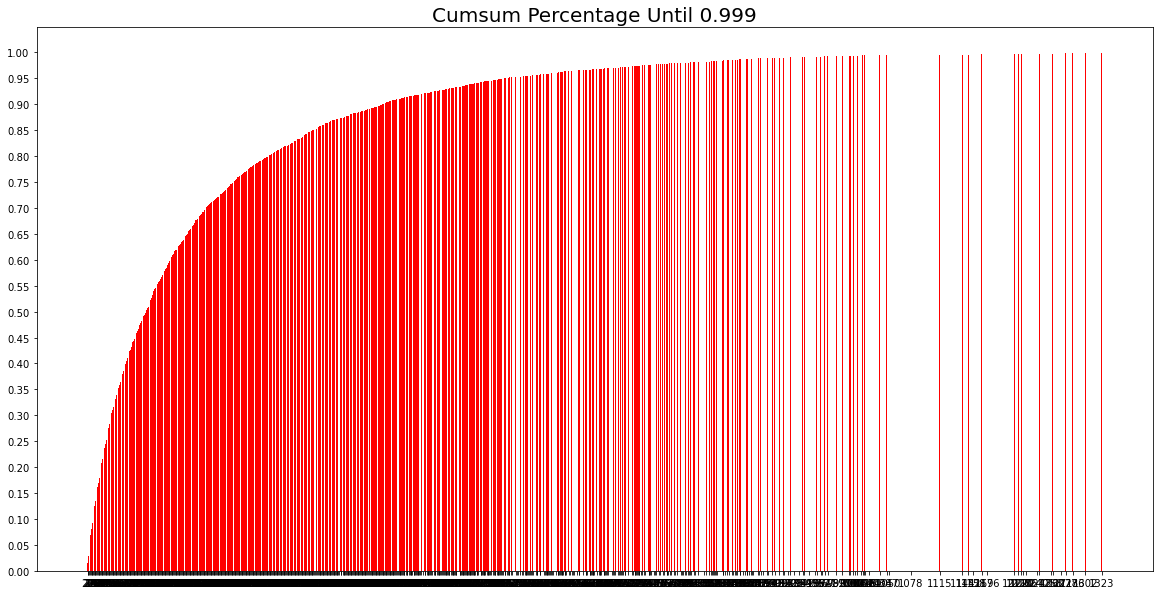

In [232]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [233]:
# 우리가 다루는 데이터의 시간정보
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [234]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [295]:
data['ItemId'].quantile(0.005)

7.0

In [296]:
data = cleanse_recursive(data, shortest=2, least_click=8)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [297]:
data['Time'].max()

1046454590

In [298]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.sort_values(by=['Time'])
    user_in_train = user_last_time[user_last_time['Time']<=final_time-n_days]
    user_in_test = user_last_time[user_last_time['Time']>final_time-n_days]

    #before_date = data[data['UserID'].isin(user_in_train)]#작은거
    #after_date = data[data['UserId'].isin(user_in_test)]#큰거
    #after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return user_in_train, user_in_test

In [299]:
data['Time'].quantile(0.95)

993072912.8000001

In [300]:
tr, test = split_by_date(data, n_days=7889400)
tr, val = split_by_date(tr, n_days=7889400)

In [301]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [302]:
data['Time'].min()

956703932

In [303]:
data['Time'].max()

1046454590

In [304]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 990201
	 Users: 6039
	 Items: 3319
	 First Time : 956703932
	 Last Time : 1030648979

* valid Set Stats Info
	 Events: 4204
	 Users: 237
	 Items: 1757
	 First Time : 1030665320
	 Last Time : 1038547696

* test Set Stats Info
	 Events: 4632
	 Users: 236
	 Items: 1814
	 First Time : 1038587326
	 Last Time : 1046454590



In [305]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

### Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.
단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

In [306]:
class UserDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [307]:
tr_dataset = UserDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,956703932,0
1000153,6040,2384,4,956703954,1
999873,6040,593,5,956703954,2
1000192,6040,2019,5,956703977,3
1000007,6040,1961,4,956703977,4
999967,6040,3111,5,956704056,5
999980,6040,3505,4,956704056,6
999920,6040,213,5,956704056,7
999877,6040,1419,3,956704056,8
999868,6040,573,4,956704056,9


In [308]:
tr_dataset.click_offsets

array([     0,     53,    182, ..., 989737, 989860, 990201], dtype=int32)

In [309]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [310]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: UserDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [311]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
1000138,6040,858,4,956703932,0
1000153,6040,2384,4,956703954,1
999873,6040,593,5,956703954,2
1000192,6040,2019,5,956703977,3
1000007,6040,1961,4,956703977,4
999967,6040,3111,5,956704056,5
999980,6040,3505,4,956704056,6
999920,6040,213,5,956704056,7
999877,6040,1419,3,956704056,8
999868,6040,573,4,956704056,9


In [312]:
iter_ex = iter(tr_data_loader)

In [313]:
#반복하면 next가 계속 데이터를 만든다.
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  53 106 210]
Label Item Idx are :       [  1  54 177 211]
Previous Masked Input Idx are []


### Step 3. 모델 구성
이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.

In [316]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [317]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [318]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [330]:
#hyper-parameter를 class로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=10)

In [331]:
model = create_model(args)

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(64, 1, 3319)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 100), (64, 100)]    1026300   
_________________________________________________________________
dropout_17 (Dropout)         (64, 100)                 0         
_________________________________________________________________
dense_17 (Dense)             (64, 3319)                335219    
Total params: 1,361,519
Trainable params: 1,361,519
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [332]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [333]:
 # 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.65]

	 - Recall@10 epoch 1: 0.060185
	 - MRR@10    epoch 1: 0.020878



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0, train_loss=6.69]     

	 - Recall@10 epoch 2: 0.070023
	 - MRR@10    epoch 2: 0.026432



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.38]

	 - Recall@10 epoch 3: 0.067130
	 - MRR@10    epoch 3: 0.026902



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0, train_loss=6.5]      

	 - Recall@10 epoch 4: 0.071759
	 - MRR@10    epoch 4: 0.025543



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0, train_loss=6.64]     

	 - Recall@10 epoch 5: 0.071181
	 - MRR@10    epoch 5: 0.024604



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0, train_loss=6.51]     

	 - Recall@10 epoch 6: 0.070023
	 - MRR@10    epoch 6: 0.024623



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.48]

	 - Recall@10 epoch 7: 0.067130
	 - MRR@10    epoch 7: 0.024304



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.54]

	 - Recall@10 epoch 8: 0.066551
	 - MRR@10    epoch 8: 0.023966



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.17]

	 - Recall@10 epoch 9: 0.066551
	 - MRR@10    epoch 9: 0.023267



Evaluation:  44%|████▍     | 27/61 [00:03<00:04,  7.55it/s]

	 - Recall@10 epoch 10: 0.064236
	 - MRR@10    epoch 10: 0.023411



### Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [334]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  41%|████      | 28/68 [00:06<00:08,  4.67it/s]

	 - Recall@10: 0.128348
	 - MRR@10: 0.039975



In [335]:
#hyper-parameter를 class로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=200, drop_rate=0.1, lr=0.001, epochs=10, k=10)

model = create_model(args)


# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

 # 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/15377 [00:00<?, ?it/s]

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(64, 1, 3319)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 200), (64, 200)]    2112600   
_________________________________________________________________
dropout_18 (Dropout)         (64, 200)                 0         
_________________________________________________________________
dense_18 (Dense)             (64, 3319)                667119    
Total params: 2,779,719
Trainable params: 2,779,719
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.41]

	 - Recall@10 epoch 1: 0.059606
	 - MRR@10    epoch 1: 0.022175



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.42]

	 - Recall@10 epoch 2: 0.067130
	 - MRR@10    epoch 2: 0.027530



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.26]

	 - Recall@10 epoch 3: 0.075231
	 - MRR@10    epoch 3: 0.028222



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.26]

	 - Recall@10 epoch 4: 0.076968
	 - MRR@10    epoch 4: 0.025759



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.14]

	 - Recall@10 epoch 5: 0.067708
	 - MRR@10    epoch 5: 0.023863



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.06]

	 - Recall@10 epoch 6: 0.064815
	 - MRR@10    epoch 6: 0.022159



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.06]

	 - Recall@10 epoch 7: 0.064815
	 - MRR@10    epoch 7: 0.022308



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6]   

	 - Recall@10 epoch 8: 0.063657
	 - MRR@10    epoch 8: 0.023271



Train:   0%|          | 0/15377 [00:00<?, ?it/s, accuracy=0, train_loss=5.95]     

	 - Recall@10 epoch 9: 0.063079
	 - MRR@10    epoch 9: 0.024799



Evaluation:  44%|████▍     | 27/61 [00:03<00:04,  7.46it/s]

	 - Recall@10 epoch 10: 0.062500
	 - MRR@10    epoch 10: 0.025170



In [336]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  41%|████      | 28/68 [00:06<00:09,  4.44it/s]

	 - Recall@10: 0.127232
	 - MRR@10: 0.037947



In [337]:
#hyper-parameter를 class로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=100, drop_rate=0.1, lr=0.001, epochs=10, k=10)

model = create_model(args)


# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = UserDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = UserDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

 # 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/7688 [00:00<?, ?it/s]

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(128, 1, 3319)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 100), (128, 100)]  1026300   
_________________________________________________________________
dropout_19 (Dropout)         (128, 100)                0         
_________________________________________________________________
dense_19 (Dense)             (128, 3319)               335219    
Total params: 1,361,519
Trainable params: 1,361,519
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.35] 

	 - Recall@10 epoch 1: 0.045312
	 - MRR@10    epoch 1: 0.015112



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.24] 

	 - Recall@10 epoch 2: 0.056250
	 - MRR@10    epoch 2: 0.020437



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.21] 

	 - Recall@10 epoch 3: 0.065625
	 - MRR@10    epoch 3: 0.021370



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.14] 

	 - Recall@10 epoch 4: 0.059375
	 - MRR@10    epoch 4: 0.020794



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.16] 

	 - Recall@10 epoch 5: 0.056250
	 - MRR@10    epoch 5: 0.021628



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.11] 

	 - Recall@10 epoch 6: 0.057813
	 - MRR@10    epoch 6: 0.023527



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.08] 

	 - Recall@10 epoch 7: 0.053125
	 - MRR@10    epoch 7: 0.022310



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.06] 

	 - Recall@10 epoch 8: 0.051562
	 - MRR@10    epoch 8: 0.021267



Train:   0%|          | 0/7688 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.07] 

	 - Recall@10 epoch 9: 0.054688
	 - MRR@10    epoch 9: 0.018641



Evaluation:  17%|█▋        | 5/30 [00:01<00:05,  4.18it/s]

	 - Recall@10 epoch 10: 0.051562
	 - MRR@10    epoch 10: 0.017747



In [338]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  18%|█▊        | 6/34 [00:02<00:12,  2.32it/s]

	 - Recall@10: 0.127604
	 - MRR@10: 0.046488



첫번째에 비해 hsz와 배치사이즈를 각각 키워봤는데, 학습할 특징양을 높이고, 배치사이즈를 키워 학습을 빨리해 train loss는 원본에 비해서 빨리 줄었습니다. 대신 특징양을 높인 경우에는 과적합인지 원본보다 test에서 점수가 떨어졌고, 배치를 많이 키운 경우는 학습이 빠르게 되서 점수가 크게 상승했습니다. 고로 긍정적인 방향은 배치사이즈를 키운 경우였습니다.